#Branching Intelligence: Exploring Decision Trees and Beyond


* The main goal of this notebook is to develop a solid grasp of decision tree algorithms by actively implementing and thoroughly evaluating them.
* The implementations are simple and original without referencing external implementation codes or tutorials.
*Please note that the final versions are different from my initial implementations to optimize for performance speed as much as possible. However, there can be redundacies which I left to make the code more understandable.
*For better evaluation context, I will also try to compare my implementations with the library versions of the models.








In [1]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import wget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import random
from scipy import stats
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
import time
%matplotlib inline

<h3 style="font-size: 20px;">Let's create a Node class which will be implemented within our custom decision tree model</h3>



In [3]:
class Node:
  def __init__(self):
    self.right = None
    self.left = None
    # define split attribute as well as threshold for attribute split
    self.split_attr = None
    self.split_threshold = None
    # Check if leaf node
    self.leaf = False
    # Label of the node (using the majority class)
    self.label = None
    # Contains class distribution in the node
    self.dist = []

Before implementing the decision tree model let's dicuss how decision trees work. If you are familiar please skip this part.

Decision Trees are supervised classification algorithms that are widely used in classification and regression problems. In this notebook I will focus on the classification part only.

The way decision trees work is through repeated **decision** process where it recursively compares attributes of a sample object to certain thresholds and follows appropriate branches.

Each series of decisions create a unique path that reaches different leaf nodes. Thus, the classification is made when it reaches the leaf nodes.


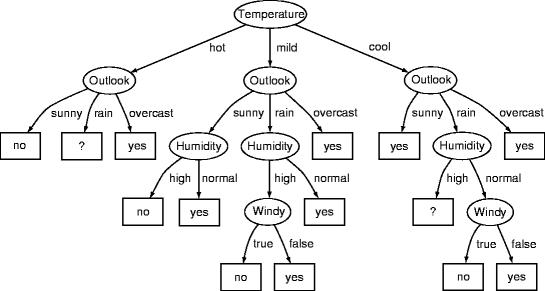

A natural question to ask is: "How do we select appropriate attributes for each level on which we perform splits?"

As a matter of fact, there are several criteria that determine the best attribute to split. Two of which are: "**Gini Index**" and "**Entropy**".

Both of these criteria determine how much information gain / impurity reduction does a given **attribute split** give. When we say information gain you can think of it as the amount of reduction in **disordered/chaotic/heterogeneous** state.

Please note that although both Gini and Entropy can act as a valid criterion  for impurity reduction / information gain, they are **not exactly same.**

In short Gini index determines the **probability of misclassifying** a randomly selected sample from a dataset. Intuitively, greater impurity would generally imply greater rate of missclassification given a particular distribution. Entropy on the other hand, gives an estimate of how **impure/mixed** a particular state is.

Hence we prefer low quantities of these estimates.


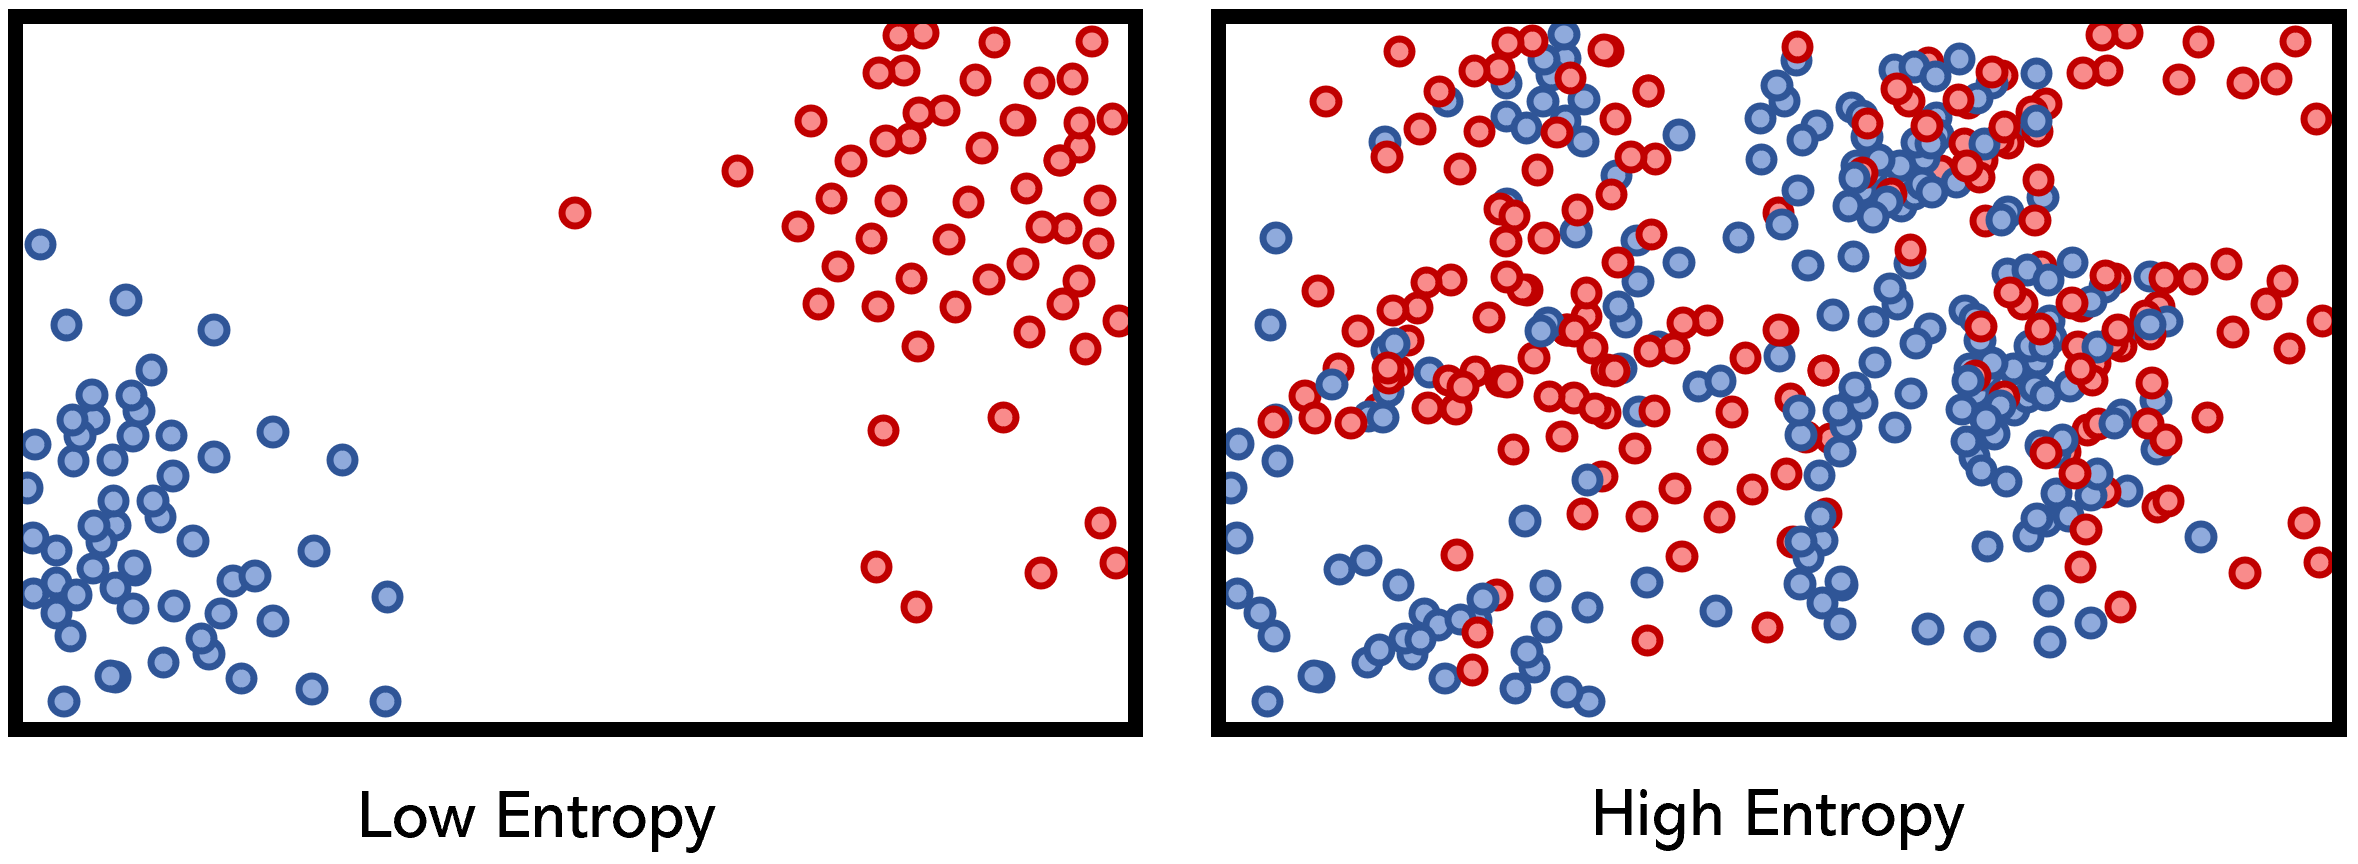

For a detailed breakdown of the model please read:

*   "**Probabilistic Machine Learning"** by Kevin Murphy  Ch-18.1.2
*   https://ocw.mit.edu/courses/15-097-prediction-machine-learning-and-statistics-spring-2012/f5678de0e329ce097fc6ec6182ebaea2_MIT15_097S12_lec08.pdf



Now I'll briefly show the important mathematical entities to be used in the model.

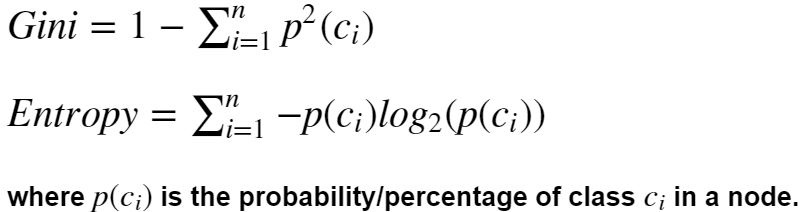

# **Procedure**

The way we grow decision trees is through attribute partitioning. Our main goal

---

is: At each level, determine best attributes as well their thresholds that best splits the dataset. This best split is determined by the amount of impurity reduction / information gain that a particular attribute split would yield.


---


Once we find the best attribute with its corresponding threshold, we split the node containing the samples. As a result, we partition the data samples into several child nodes. For each of these child nodes we repeat the previous step. You can probably picture how this can be done recursively.


---


Once we reach a pure node (with homogeneuos class) or a node that can't be divided further (no possible split would give enough impurity reduction) we halt.

* As a first step, I will attempt to implement my own decision tree model by following the mathematical formulation provided on the sklearn website:

* https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart

* In sklearn, decision trees are designed to handle binary splits to better accommodate numeric attributes. This means we need to preprocess the data before feeding it in our model.

* During my research on sklearn's decision trees, I discovered some important facts:
  1. The decision tree implementation in sklearn supports only binary splits.
  2. When selecting a threshold from attribute values, the evaluation considers midpoints between two adjacent values.



<h3 style = 'font-size: 20px;'> Now let's build our base class for the decision tree

In [4]:
class MyTreeClassifier:

  def __init__(self, criterion = 'gini', max_depth=1000, n_features = None, feauture_sampling = False, random_state = None):
    # When we initialize the tree we have root node by default however since there are no splits yet left and right childs are set to None
    self.root = Node()
    # We can select a criterion for split i set the default to gini which is default like sklearn
    # Depending on the critertion one of two possible split functions will be called: 1. using Gini 2. using Entropy
    self.criterion = criterion
    self.max_depth = max_depth
    self.feature_sampling = feauture_sampling
    self.n_features = n_features
    self.random_state = random_state

  # In case we need to update our parameters before fitting we create the following function
  def set_params(self, **params):
    for param, val in params.items():
      setattr(self, param, val)

  def calculate_gini(self, y):
    #calculate number of samples in the node
    sample_count = len(y)
    #obtain labels and corresponding number of samples for that label
    class_labels, class_counts = np.unique(y, return_counts = True)
    #calculate and return gini index
    class_probs = class_counts / sample_count
    node_gini = 1 - np.sum(class_probs ** 2)
    return node_gini

  def calculate_entropy(self, y):
    sample_count = len(y)
    class_labels, class_counts = np.unique(y, return_counts = True)
    #calculate and return entropy of the node
    class_probs = class_counts / sample_count
    node_entropy = np.sum(-class_probs * np.log2(class_probs))
    return node_entropy

  def node_split(self, node, X, y, depth):
    if(self.random_state != None): np.random.seed(self.random_state)

    if(self.criterion == 'gini'): node_gini = self.calculate_gini(y)
    else: node_entropy = self.calculate_entropy(y)

    # Label of a node is determined by majority vote of class distribution this is useful when we use max_depth
    labels, label_counts = np.unique(y, return_counts = True)
    node.label = labels[np.argmax(label_counts)]

    # Insert the class distribution inside the node
    node.dist = (label_counts/sum(label_counts))

    # If the mode has reached max_depth or if it has 0 impurity then we stop
    if(depth == self.max_depth): node.leaf = True; return
    elif(self.criterion == 'gini' and node_gini == 0): node.leaf = True; return
    elif(self.criterion == 'entropy' and node_entropy == 0): node.leaf = True; return

    # else we find the best attribute for split
    # initialize best Impurity Reduction to 0; this will be the best IR among all attributes splits
    best_IR = 0
    # create an array to store sample indices for left and right partitions
    left_partition =  None
    right_partition = None

    attributes = np.arange(X.shape[1])
    # Ignore this part for now as since it will be used in the later part
    if (self.feature_sampling == True and self.n_features):
        attributes = np.random.choice(range(X.shape[1]), self.n_features, replace=False)

    #{START LOOP}

    for attribute in attributes:
      # select all unique values for particular attribute (sorted by default after np.unique)
      attribute_values = np.unique(X[:,attribute])
      # initialize impurity reduction for given attribute split to 0
      # our goal is to find best split threshold for given attribute
      attr_IR = 0
      attr_left_partition = None
      attr_right_partition = None

      # test each candidate threshold among list of unique values in an attribute for impurity reduction

      quantile_approx = len(attribute_values) > 20

      if quantile_approx:
        # If there are large number of split candidates within an attribute, use quantiles for approximation
        # Here I use 10 bins to describe the samples
        threshold_values = np.quantile(attribute_values, np.arange(0.1, 1.0, 0.1))
      else:
        # In this part we calculate midpoint between every unique value
        # attribute_values[:-1] selects all values except last value in array
        # attribute_values[1:] selects all values except first value in the array
        threshold_values = (attribute_values[:-1] + attribute_values[1:]) / 2

      for threshold in threshold_values:
        # select samples corresponding to left and right nodes
        left_node_indices = X[:,attribute] <= threshold
        right_node_indices = ~left_node_indices

        if(self.criterion == 'gini'):

          # calculate gini indices for left and right child nodes
          gini_left = self.calculate_gini(y[left_node_indices])
          gini_right = self.calculate_gini(y[right_node_indices])

          # calculate ratio of samples in left and right partitions
          # note that this is same as np.sum(left_node_indices)/len(y)
          LP_coeff = np.mean(left_node_indices)
          RP_coeff = np.mean(right_node_indices)

          # calculate the gini index for the given attribute split
          gini_attr_split = LP_coeff * gini_left + RP_coeff * gini_right

          # calculate impurity reduction / information gain
          IR = node_gini - gini_attr_split

        else:
          # calculate entropies for left and right child nodes
          entropy_left = self.calculate_entropy(y[left_node_indices])
          entropy_right = self.calculate_entropy(y[right_node_indices])

          LP_coeff = np.mean(left_node_indices)
          RP_coeff = np.mean(right_node_indices)

          entropy_attr_split = LP_coeff * entropy_left + RP_coeff * entropy_right
          IR = node_entropy - entropy_attr_split

        if(IR > attr_IR):
          #if current threshold gives better IR for given attribute, update the quantities
          attr_IR = IR
          split_threshold = threshold
          attr_left_partition =  left_node_indices
          attr_right_partition = right_node_indices

      #{END LOOP}

      # check if the current attribute gives better information gain
      if(attr_IR > best_IR):
         best_IR = attr_IR
         #update best split attribute for given node as well as split threshold
         node.split_attr = attribute
         node.split_threshold = split_threshold
         #correspindingly update sample partitions for left and right node
         left_partition = attr_left_partition
         right_partition = attr_right_partition
         #if partitions are nonzero size then create a child node

    # if there's no information gain then stop splitting
    if(best_IR == 0): node.leaf = True; return
    # else call node_split for the left and right child nodes
    node.left = Node()
    self.node_split(node.left, X[left_partition], y[left_partition], depth+1)
    node.right = Node()
    self.node_split(node.right, X[right_partition], y[right_partition], depth+1)

  def fit(self, X, y):
    # Check if the data is a pandas object or python list, if so convert to numpy for better speed
    if(isinstance(X, (pd.DataFrame, pd.Series))):
      X = X.to_numpy()
    elif(isinstance(X, list)):
      X = np.array(X)
    if(isinstance(y, (pd.DataFrame, pd.Series))):
      y = y.to_numpy()
    elif(isinstance(y, list)):
      y = np.array(y)
    # When we call train function we feed the tree with data and label and call split which will be a recursive funcion
    self.node_split(self.root, X, y, depth=0)

  def recursive_check(self, node, X, proba):
    #This is the function that predicts the label using decision tree thresholds
    if(node.leaf == True):
      # I have also added a condition to return class probability
      # This probability is determined by the class distribution in the leaf node during training phase
      if(proba == False): return node.label
      else: return node.dist
    else:
      split_attr = node.split_attr
      split_threshold = node.split_threshold
      if(X[split_attr] <= split_threshold): return self.recursive_check(node.left, X, proba)
      else: return self.recursive_check(node.right, X, proba)

  def predict(self, X, proba = False):
    if(isinstance(X, (pd.DataFrame, pd.Series))):
      X = X.to_numpy()
    elif(isinstance(X, list)):
      X = np.array(X)
    # if input is a single sample then return its prediction
    # else return numpy array of predictions
    if(X.ndim == 1): return self.recursive_check(self.root, X, proba = proba)

    predictions = []
    for sample in X:
      prediction = self.recursive_check(self.root, sample, proba)
      predictions.append(prediction)
    return np.array(predictions)



In [5]:
from sklearn.datasets import load_iris

In [6]:
iris = load_iris()
X = iris.data
y = iris.target

In [7]:
label_names = [iris.target_names[label] for label in y]

X_vis = pd.DataFrame(X, columns = iris.feature_names)
y_vis = pd.DataFrame(label_names, columns=['label'])


In [8]:
pd.concat([X_vis, y_vis], axis = 1).head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [9]:
def eval_accuracy(my_estimator, lib_estimator, X, y, params, test_size, ensemble =False, random_state = 0):
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state = random_state)

  clf1 = my_estimator
  clf1.set_params(**params)
  clf1.fit(x_train, y_train)

  clf2 = lib_estimator
  clf2.set_params(**params)
  clf2.fit(x_train, y_train)

  score1 = accuracy_score(y_test, clf1.predict(x_test))
  score2= accuracy_score(y_test, clf2.predict(x_test))

  print('Custom Model:')
  if(ensemble == False): print('Criterion:', clf1.criterion)
  else: print('Criterion:', clf1.estimator.criterion)
  print('Accuracy:', score1)
  print('---')
  print('Library Model:')
  if(ensemble == False): print('Criterion:', clf2.criterion)
  else: print('Criterion:', clf2.estimator.criterion)
  print('Accuracy:', score2)
  print('---\n')



In [10]:
params = {'criterion' : 'gini', 'random_state' : 42}
eval_accuracy(MyTreeClassifier(), DecisionTreeClassifier(), X, y, params, test_size = 0.5, random_state = 42)
params = {'criterion' : 'entropy', 'random_state' : 42}
eval_accuracy(MyTreeClassifier(), DecisionTreeClassifier(), X, y, params, test_size = 0.5, random_state = 42)

Custom Model:
Criterion: gini
Accuracy: 0.9333333333333333
---
Library Model:
Criterion: gini
Accuracy: 0.9066666666666666
---

Custom Model:
Criterion: entropy
Accuracy: 0.92
---
Library Model:
Criterion: entropy
Accuracy: 0.92
---



In [11]:
clf = DecisionTreeClassifier()
clf.fit(X, y)

DecisionTreeClassifier()

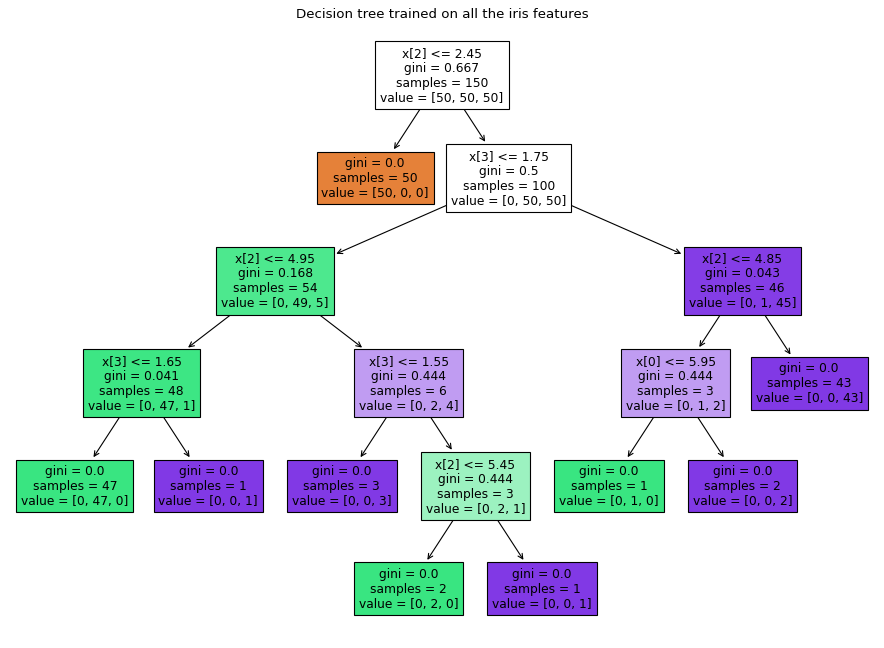

In [12]:
from sklearn.tree import plot_tree
plt.figure(figsize=(14, 10), dpi=80)
plot_tree(clf, filled=True)
plt.title("Decision tree trained on all the iris features")
plt.show()

#### Let's use max_depth = 1 (Decision stump)


In [13]:
params = {'max_depth' : 1, 'random_state' : 42}
eval_accuracy(MyTreeClassifier(), DecisionTreeClassifier(), X, y,  params, test_size = 0.2, random_state = 42)
params = {'max_depth' : 1, 'criterion' : 'entropy', 'random_state' : 42}
eval_accuracy(MyTreeClassifier(), DecisionTreeClassifier(), X, y,  params, test_size = 0.2, random_state = 42)

Custom Model:
Criterion: gini
Accuracy: 0.6333333333333333
---
Library Model:
Criterion: gini
Accuracy: 0.6333333333333333
---

Custom Model:
Criterion: entropy
Accuracy: 0.6333333333333333
---
Library Model:
Criterion: entropy
Accuracy: 0.6333333333333333
---



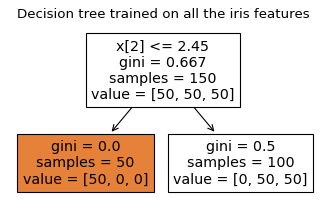

In [14]:
clf = DecisionTreeClassifier(max_depth = 1)
clf.fit(X, y)
plt.figure(figsize=(5, 3), dpi=80)
plot_tree(clf, filled=True)
plt.title("Decision tree trained on all the iris features")
plt.show()

In [15]:
link = 'https://drive.google.com/uc?id=1EGhieejlblENS-ZBq350DSXq9-llkG--&export=download'

wget.download(link, '/content/dataset.zip')




'/content/dataset (1).zip'

In [16]:
import zipfile
with zipfile.ZipFile('/content/dataset.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/heart_data')

In [17]:
data = pd.read_csv('/content/heart_data/heart.csv')

#### Now let's try our model on a more diverse data
#### I'll use the HeartDisease prediction data from kaggle

#HeatDisease Data Preprocessing

In [18]:
data.tail(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1
917,38,M,NAP,138,175,0,Normal,173,N,0.0,Up,0


In [19]:
X = data.drop('HeartDisease', axis = 1)
y = data['HeartDisease']

In [20]:
statistics = data.describe()
unique_vals = pd.Series([len(data[feature].unique()) for feature in data.columns], name ='unique_values')
unique_vals = dict(zip(data.columns, unique_vals))


In [21]:
unique_vals

{'Age': 50,
 'Sex': 2,
 'ChestPainType': 4,
 'RestingBP': 67,
 'Cholesterol': 222,
 'FastingBS': 2,
 'RestingECG': 3,
 'MaxHR': 119,
 'ExerciseAngina': 2,
 'Oldpeak': 53,
 'ST_Slope': 3,
 'HeartDisease': 2}

###Let's visualize the data distribution


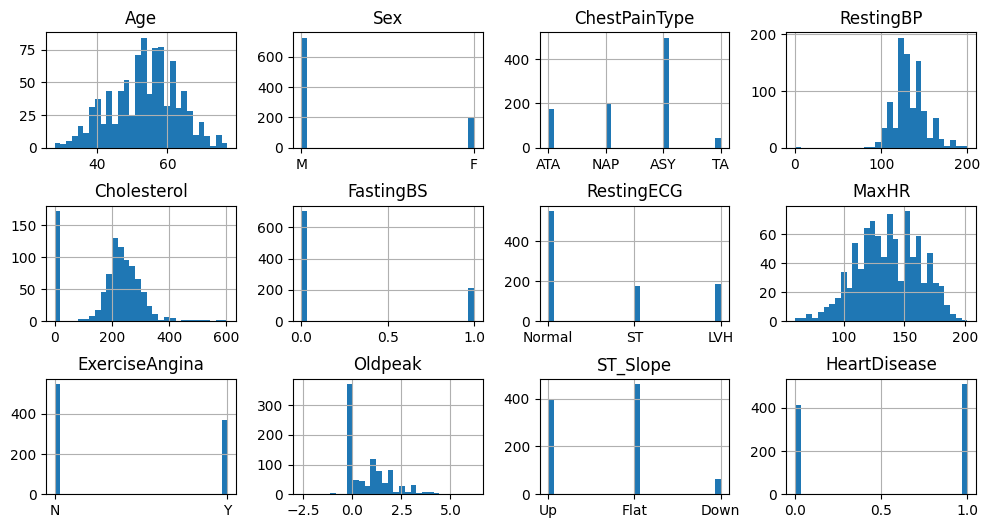

In [22]:
features = data.columns
fig, axes = plt.subplots(nrows=3, ncols=4, figsize = (12,6))
for i in range(3):
  for j in range(4):
    data[features[i*4+j]].hist(ax=axes[i,j], bins = 30)
    axes[i,j].set_title(features[i*4+j])
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

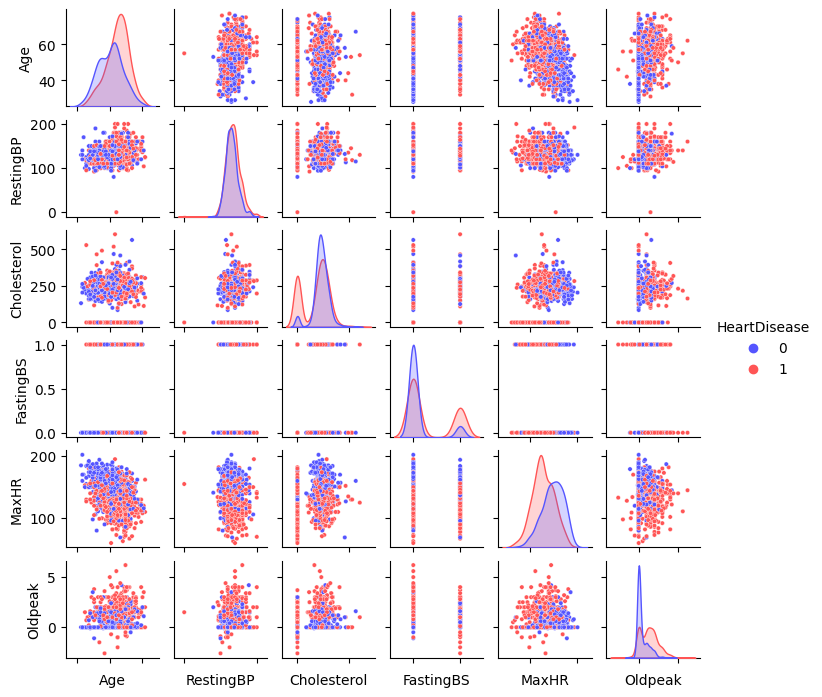

In [23]:
g = sns.pairplot(data=data, hue='HeartDisease', palette = 'seismic',
                 height=1.2,diag_kind = 'kde',diag_kws=dict(fill=True),plot_kws=dict(s=10),
                 )
g.set(xticklabels=[])

Let's preprocess our data before training our models

As mentioned before, since our model processes numeric data, it's important that we perform numeric encoding to categorical attributes

For attributes that potentially have some natural ordering or that have 2 classes only we use ordinal encoding

For nominal categorical (no order/hierarchy) attributes we use one-hot encoding

**Note: &nbsp; The preprocessing steps I do may not be optimal since our main goal is to compare our model with a validated model.**

In [24]:
def data_encoder(X):
    # Define the mappings for each attribute
    mappings = {
        'Sex': {'M': 0, 'F': 1},
        'ST_Slope': {'Down': 0, 'Flat': 1, 'Up': 2},
        'ExerciseAngina': {'N': 0, 'Y': 1}
    }

    for attribute, mapping in mappings.items():
        X[attribute] = X[attribute].map(mapping)

    ordinal_features = ['RestingECG', 'ChestPainType']
    for feature in ordinal_features:
        one_hot_encoder = OneHotEncoder(sparse = False)
        one_hot_encoded = one_hot_encoder.fit_transform(X[[feature]])
        df = pd.DataFrame(one_hot_encoded, columns = feature + "_"  + X[feature].apply(str).unique())
        X.drop(feature, axis = 1, inplace = True)
        X = pd.concat([X, df], axis=1)

    return X

In [25]:
X = data_encoder(X)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [26]:
X.head(5)

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,RestingECG_Normal,RestingECG_ST,RestingECG_LVH,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_ASY,ChestPainType_TA
0,40,0,140,289,0,172,0,0.0,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,49,1,160,180,0,156,0,1.0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,37,0,130,283,0,98,0,0.0,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,48,1,138,214,0,108,1,1.5,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,54,0,150,195,0,122,0,0.0,2,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Let's evalute our tree model for the HeartDisease prediction dataset

In [27]:
params = {'max_depth': 5, 'random_state' : 42}
eval_accuracy(MyTreeClassifier(), DecisionTreeClassifier(), X, y, params, test_size = 0.2, random_state = 0)
params = {'max_depth': 5, 'criterion' : 'entropy', 'random_state' : 42}
eval_accuracy(MyTreeClassifier(), DecisionTreeClassifier(), X, y, params, test_size = 0.2, random_state = 0)

Custom Model:
Criterion: gini
Accuracy: 0.7880434782608695
---
Library Model:
Criterion: gini
Accuracy: 0.7880434782608695
---

Custom Model:
Criterion: entropy
Accuracy: 0.8152173913043478
---
Library Model:
Criterion: entropy
Accuracy: 0.8206521739130435
---



#Bagging Classifier

#### Now let's implement Bagging Classifiers.
#### Often times single Decision Trees are often prone to overfitting and bias. However a simple way to overcome this is to use more than one decision tree and rely on majority voting system.
#### The main idea is to train each tree with a randomly sampled subset of the data rather than using the entire training set.
#### There are however, disadvantages to this. It's that on average each model will only see ~ 63% unique samples provided that number of sample N is large.



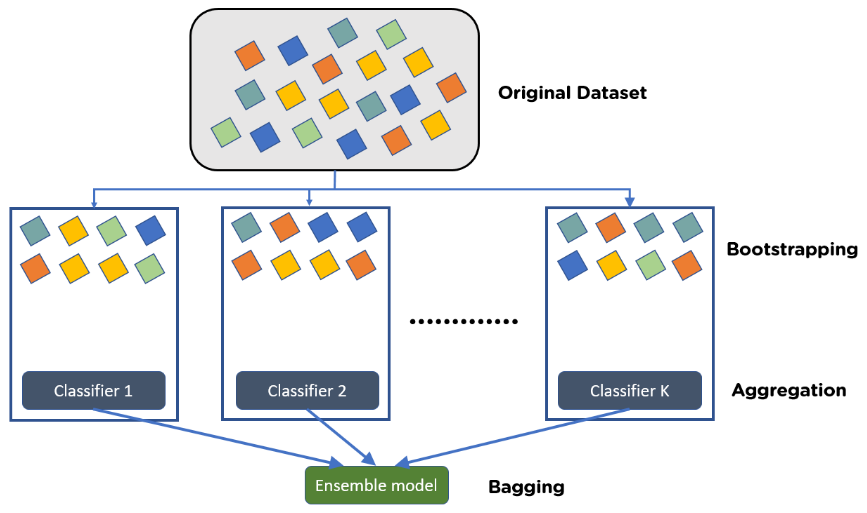

In [28]:
class CustomBaggingClassifier:
  #Initialize an instance of a BaggingClassifier and set dafault parameters
  def __init__(self, estimator = None, bootstrap = True, max_samples = 1.0,
               n_estimators = 10, random_state = None):
    # Whether or not sample with replacement (default = True)
    self.bootstrap = bootstrap
    self.max_samples = max_samples
    self.n_estimators = n_estimators
    self.estimator = estimator
    self.random_state = random_state

  def set_params(self, **params):
    for param, val in params.items():
      setattr(self, param, val)

  def fit(self, X, y):
    if(self.random_state != None): np.random.seed(self.random_state)
    # Raise error if fit is called for undefined estimator type
    if(self.estimator == None): raise Exception('Undefined Estimator')

    # Array for storing n estimators
    # We can use deepcopy to create n independent copies of the base estimator
    self.estimators = [copy.deepcopy(self.estimator) for i in range(self.n_estimators)]

    if(isinstance(X, (pd.DataFrame, pd.Series))):
      X = X.to_numpy()
    elif(isinstance(X, list)):
      X = np.array(X)
    if(isinstance(y, (pd.DataFrame, pd.Series))):
      y = y.to_numpy()
    elif(isinstance(y, list)):
      y = np.array(y)

    if(type(self.max_samples) == int): sample_size = self.max_samples
    elif(type(self.max_samples == float)): sample_size = int(self.max_samples * X.shape[0])
    else: raise TypeError('TypeError for max_sample')

    # Fit each base model with randomly sampled data
    for estimator in self.estimators:
      # Randomly sample n samples from the training dataset
      sampled_indices = np.random.choice(X.shape[0], sample_size, replace=self.bootstrap)
      sampled_x = X[sampled_indices]
      sampled_y = y[sampled_indices]

      # Train an instance of an estimator
      estimator.fit(sampled_x, sampled_y)

  def predict(self, X):
    if(isinstance(X, (pd.DataFrame, pd.Series))):
      X = X.to_numpy()
    elif(isinstance(X, list)):
      X = np.array(X)

    predictions = np.array([estimator.predict(X) for estimator in self.estimators])
    # Each tree will return n predictions thus we will have (n_trees x n_samples) ndarray
    # We want to rely on the majority vote, thus we pick the mode of each column in predictions array
    final_predictions = []
    for col in range(predictions.shape[1]):
      pred_labels, label_counts = np.unique(predictions[:,col], return_counts=True)
      final_predictions.append(pred_labels[np.argmax(label_counts)])
    return np.array(final_predictions)



Let's perform perfomance analysis on our classifier.

Feel free to change the parameters!

I set the max_depth = 5 &nbsp; (Usually it is good idea to set a maximum depth through parameter tuning. If max depth is too high, the classifier will suffer from overfitting and underform for test data, opposite is also the case as it leads to underfitting)

In [29]:
BAG_custom = CustomBaggingClassifier(MyTreeClassifier(max_depth = 5))
BAG_library = BaggingClassifier(DecisionTreeClassifier(max_depth = 5))

params = {'max_samples' : 0.6, 'n_estimators' : 80, 'random_state' : 24}
eval_accuracy(BAG_custom, BAG_library, X, y, test_size = 0.2, params=params, ensemble = True, random_state = 24)


Custom Model:
Criterion: gini
Accuracy: 0.8532608695652174
---
Library Model:
Criterion: gini
Accuracy: 0.842391304347826
---



#Random Forest Classifier

We saw that the performance of a single decision tree was decent enough as it is with ~ 80%. However, using bagging classifier improved the accuracy to ~ 83-84% which is still notable.

Now that we have seen bagging classifiers let's proceed to another popular model: RandomForestClassifier.
RandomForestClassifier as its name implies is an ensemble model that uses $N$ decision trees. It's almost same as BaggingClassifiers, however it introduces one more step of randomness.

Unlike BaggingClassifiers which evaluates split features from entire feature set $F$, RandomForests evaluate features to split from randomly selected subset of features
$F' \subseteq F$ for each tree.

Now here is the problem there are two possible ways to implement RandomForests:
 1. Feature selection at tree level (by Tin Kam Ho 1995)
 2. Feature selection at node level (by Leo Breiman 2001)

Since RandomForest is almost same as BaggingClassifier we can inherit almost everything from CustomBaggingClassifier class and overwrite the fit function.




In [30]:
class RFClassifier(CustomBaggingClassifier):
    # Inherit the functionality from the BaggingClassifier
    # We need to put additional changes to the constructor
    def __init__(self, max_features = 1.0, max_depth = 1000, n_estimators = 100,
                 feature_sample_type =True, random_state = None, **kwargs):
        # call the parent classes init function
        super().__init__(**kwargs)
        self.feature_sample_type = feature_sample_type
        self.max_features = max_features
        self.estimator = MyTreeClassifier(max_depth=max_depth)
        self.n_estimators = n_estimators
        self.random_state = random_state

    # Override the fit function from BaggingClassifier
    # Almost everything is same except additional feature subset selection for base classifiers
    def fit(self, X, y):
      if(self.random_state != None): np.random.seed(self.random_state)
      if(self.estimator == None): raise Exception('Undefined Estimator')

      #NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW #
      # Calculate number of featuers in the data:
      n_features = X.shape[1]
      # Handle different cases for max_features:
      if(type(self.max_features) == int):
        n_features = self.max_features
      elif(type(self.max_features) == float):
        n_features = max(1, int(self.max_features * n_features))
      elif(self.max_features == 'sqrt' or self.max_features == 'auto'):
        n_features = max(1, int(np.sqrt(n_features)))
      elif(self.max_features == 'log2'):
        n_features = max(1, int(np.log2(n_features)))

      # This is to store sampled feature indices for each decision tree;
      # This is only needed if we sample features at tree level; detailed explanation will be given later
      self.tree_features = []
      #NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW #


      if(isinstance(X, (pd.DataFrame, pd.Series))):
        X = X.to_numpy()
      elif(isinstance(X, list)):
        X = np.array(X)
      if(isinstance(y, (pd.DataFrame, pd.Series))):
        y = y.to_numpy()
      elif(isinstance(y, list)):
        y = np.array(y)

      if(type(self.max_samples) == int): sample_size = self.max_samples
      elif(type(self.max_samples == float)): sample_size = int(self.max_samples * X.shape[0])
      else: raise TypeError('TypeError for max_sample')

      # When using feature_sample_type 2 allow decision trees to feature sample at node levels
      if (self.feature_sample_type == 2):
          params = {'feature_sampling' : 1, 'n_features' : n_features}
          self.estimator.set_params(**params)

      # Create n estimator intances
      self.estimators = [copy.deepcopy(self.estimator) for i in range(self.n_estimators)]

      for estimator in self.estimators:


        #NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW #
        X_estimator = X

        if(self.feature_sample_type == 1):
          # Randomly sample n features from the features set
          # This is done if we are sampling features at each tree
          feature_indices = np.random.choice(range(X.shape[1]), n_features, replace=False)
          X_estimator = X[:,feature_indices]
          self.tree_features.append(feature_indices)

        #NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW #


        sampled_indices = np.random.choice(X.shape[0], sample_size, replace=self.bootstrap)
        sampled_x = X_estimator[sampled_indices]
        sampled_y = y[sampled_indices]

        # Train an instance of an estimator
        estimator.fit(sampled_x, sampled_y)

    # Although everything seems complete there's another crucial thing we need to change
    # That is we need to tweak the predict function if we are sampling features at tree level
    # By default our predict function takes data with all its dimensions (say 14 dimensions)
    # Since our custom decision tree saves the split attributes as array index
    # A tree trained with 3 randomly selected features/columns [3,5,9] will store these as [0,1,2]
    # So when we use predict it will take columns 0 1 2 from our test data which is wrong.
    # To deal with this issue we preprocess our data before we predict.
    def predict(self, X):
      if(isinstance(X, (pd.DataFrame, pd.Series))):
        X = X.to_numpy()
      elif(isinstance(X, list)):
        X = np.array(X)

      #NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW #
      predictions = []
      for idx, estimator in enumerate(self.estimators):
        # If feature_sample_type == 1 (tree level feature sampling then give each classifier appropriate data subset)
        if(self.feature_sample_type == 1):
          tree_features = self.tree_features[idx]
          X_subset = X[:,tree_features]
        else:
          X_subset = X
        predictions.append(estimator.predict(X_subset))

      predictions = np.array(predictions)
      #NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW NEW #

      final_predictions = []
      for col in range(predictions.shape[1]):
        pred_labels, label_counts = np.unique(predictions[:,col], return_counts=True)
        final_predictions.append(pred_labels[np.argmax(label_counts)])
      return np.array(final_predictions)


Let us perform performance analysis against the sklearn library version of RandomForestClassifier
Feel free to change the params!

In [31]:

RF_library = RandomForestClassifier()
params = {'max_features' : 0.6, 'max_samples' : 0.6, 'max_depth' : 5, 'n_estimators' : 80, 'random_state' : 24}

print("Tree level feature sampling:\n")
RF_custom = RFClassifier(feature_sample_type = 1)
eval_accuracy(RF_custom, RF_library, X, y, test_size = 0.2, params=params, ensemble = True, random_state = 24)

print("Node level feature sampling:\n")
RF_custom = RFClassifier(feature_sample_type = 2)
eval_accuracy(RF_custom, RF_library, X, y, test_size = 0.2, params=params, ensemble = True, random_state = 24)


Tree level feature sampling:

Custom Model:
Criterion: gini
Accuracy: 0.8695652173913043
---
Library Model:
Criterion: gini
Accuracy: 0.8532608695652174
---

Node level feature sampling:

Custom Model:
Criterion: gini
Accuracy: 0.8695652173913043
---
Library Model:
Criterion: gini
Accuracy: 0.8532608695652174
---



Why are RandomForests more preferred than BaggingClassifiers?
In general RandomForests tend to be slightly more effective and robust. Can you guess why?

Well it goes back to our initial discussion of overfitting and bias in the decision trees.
BaggingClassifiers, though better than single Decision Trees, could still have some correlation between base classifiers which could lead to suffering from finite residual bias.

This is where Random Forests come in. By not only training individual trees on different subsets we are also training them on different subset of features which further **decorrelates** individual base models, thereby making the overall model more generalized with less variance.



#++Boosting : AdaBoost (Adaptive Boosting)

Now that we have explored Random Forests and Bagging Classifiers let's dive further down the root or in our case further down the branches!

From now on we'll explore another popular technique which is **Boosting!**.


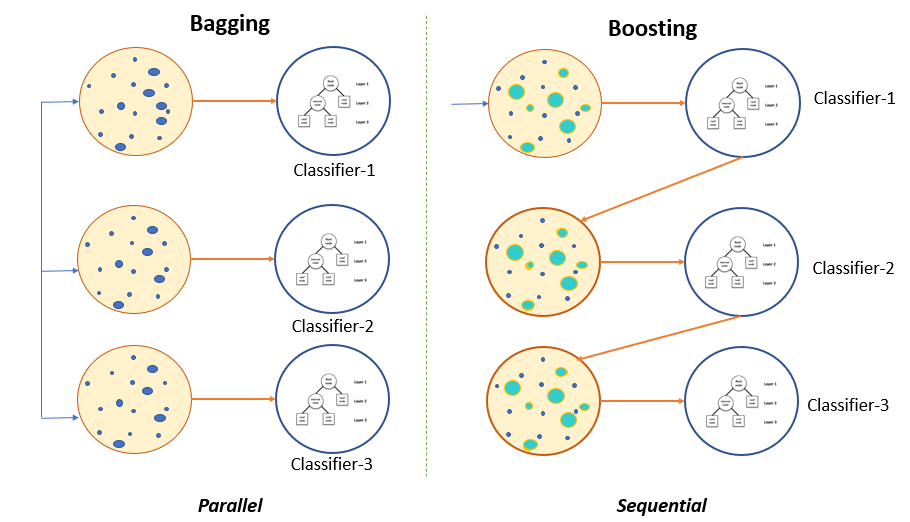

So how does **boosting** work?

Boosting can be described as an technique that creates a **strong** learner using ensemble of **weak** learners.

The iterative process works as follows : We start with a base learner model which would be a weak classifier then we progressively add more classifiers each of which progressively addresses the issues of its predecessors. In a way these weak learners complement each other!

In our case, we are effectively growing an ensemble from a single decision tree but unlike RandomForests, the models are not independently created but rather through a sequential additive process where new models learn from the mistakes of the previous misclassifications.

When it comes to other machine learning algorithms such as linear regression or neural networks it's intuitive to perform gradient descent / backpropagation, then what about decision trees?
If you think about it, intuitively there are 2 ways:
  1. Weighing the classifiers iteratively (voting importance).
  2. Giving more importance to misclassified data samples



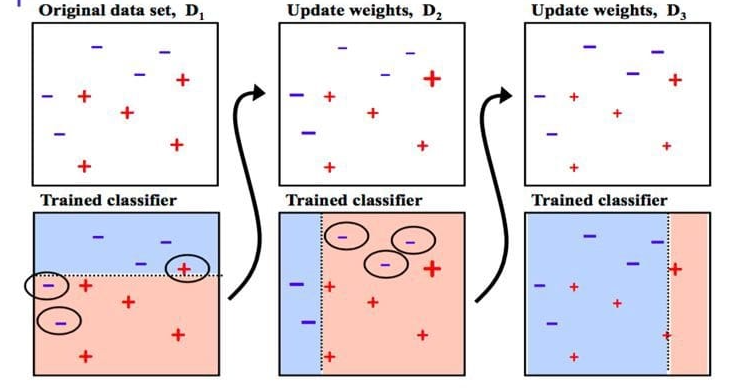



*   Why are we weighting data samples? Well, we want to create an appropriate dataset for each model by sampling from the original dataset with replacement using the weights (with normalization) as a sort of probability distribution so that we are more likely to pick missclassified samples.

* In this part, I will be implementing the AdaBoost algorithm. A very common choice of a weak learner in AdaBoost is a decision stump. Although it may seem unreliable, it can in fact show strong results!

* One can also imagine that although a single stump may only provide a straight boundary (plane or line), a boosted ensemble consisting of many weak learners can in fact build a complex nonlinear boundary that can actually capture even more complex classifications. A good parallelism is to think about Fourier Series.




# **Fourer Series Example**

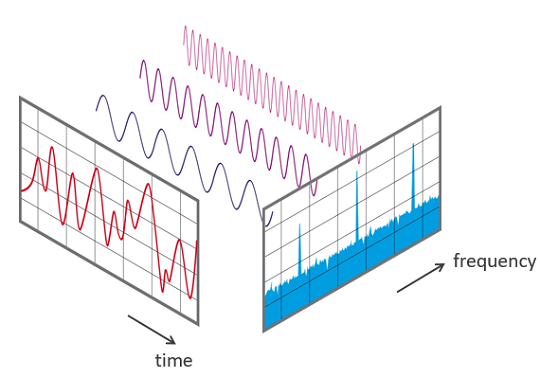

# **AdaBoost Example**

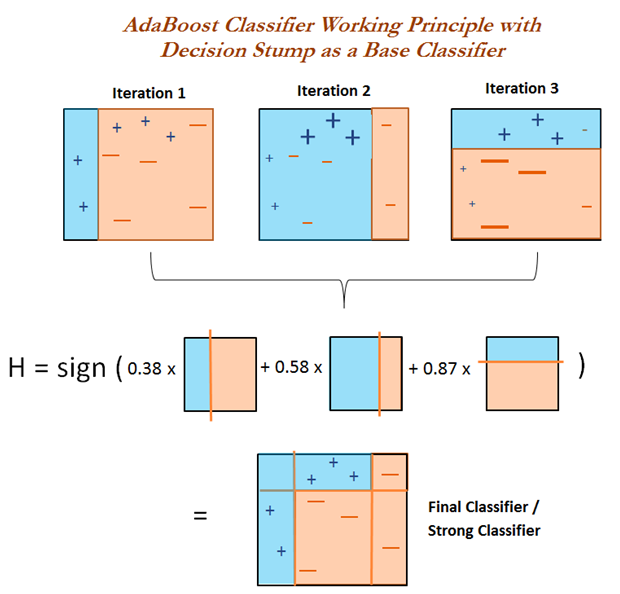

Here are more detailed explanations on the theoretical background knowledge for the algorithm.

  1. https://www.cs.toronto.edu/~mbrubake/teaching/C11/Handouts/AdaBoost.pdf
  2. Probabilistic Machine Learnign by Kevin Murphy **(Chapter 8)**

As stated before there are 2 updates needed at each iteration.
Weight of misclassified samples as well as weight of classifier. Naturally,
we weight the classifiers after evaluating their performance at end of each iteration hence:


**Weight of the $m_{th}$ classifier at iteration $m$:**

 \begin{align}
 \alpha_m = \log(\frac{(1-err_m)}{err_m}
 \end{align}


**Where:**

\begin{align} err_m = \frac{\sum_{i=1}^{N}w_{i,m} \space 𝕀\bigl(\hat{y} \ne F_m(x_i)\bigr)}{\sum_{i=1}^{N}w_{i,m}}\end{align}

<br><br/>
Here &nbsp; $𝕀\bigl(\hat{y} \ne F_m(x_i)\bigr) $ &nbsp;  is just an indicator function that returns **1** for misclassified example and **0** otherwise.
<br><br/>

On the other hand, we also need to propagate the weighted samples for the next iteration round.
<br><br/>

**Weight of the sample $x_i$ at the iteration $m$**:

\begin{align}
        w^{(i)}_{m+1} = \left\{
        \begin{array}{cl}
         &w^{(i)}_m \cdot \exp(\alpha_m) & \hat{y} \ne F_m(x_i) \\
         &w^{(i)}_m & otherwise.
        \end{array}
        \right.
\end{align}

Now that we have everything we need. Let's see the algorithm as a whole. Note that we initialize the weights to $1/N$ since all samples have same importance weight.

Although not specified in the algorithm, it's also a common choice to use a learning rate parameter to control the effect of each subsequent model. This parameter can be used to control $\alpha_m$. Note that this isn't explicitely used in the traditional AdaBoost.

 \begin{align}
 \alpha_m = LR \cdot \log(\frac{(1-err_m)}{err_m}
 \end{align}



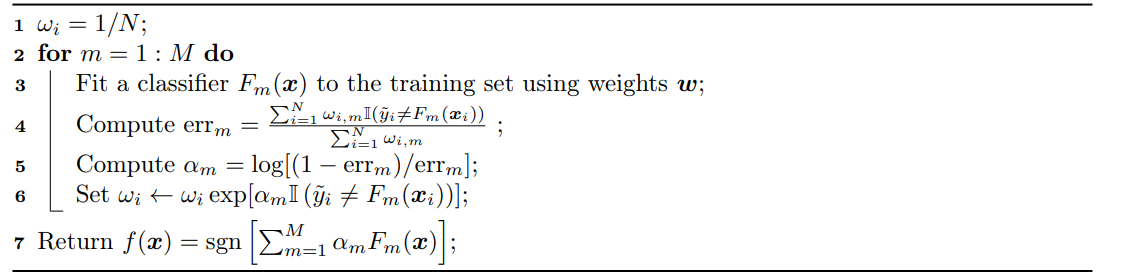

**We are going to classify classify instances by assigning 1 or -1 labels.**

**After determining the overall classification sign we can convert it to 1 or 0**

In [32]:
class CustomAdaBoost(MyTreeClassifier):
  def __init__(self, n_estimators = 100, max_depth=1000, random_state = None, learning_rate = 1.0):
    self.estimator = MyTreeClassifier(max_depth = max_depth)
    self.random_state = random_state
    self.learning_rate = learning_rate
    self.n_estimator = n_estimators
    # Create unfitted classifiers using self.estimator as a blueprint
    self.estimators = [copy.deepcopy(self.estimator) for i in range(n_estimators)]
    # Initialize weight array for classifier weights (will be updated during the iterations)
    self.clf_weights = []


  def fit(self, X, y):
    self.estimators = [copy.deepcopy(self.estimator) for i in range(self.n_estimators)]

    if(isinstance(X, (pd.DataFrame, pd.Series))):
      X = X.to_numpy()
    elif(isinstance(X, list)):
      X = np.array(X)
    if(isinstance(y, (pd.DataFrame, pd.Series))):
      y = y.to_numpy()
    elif(isinstance(y, list)):
      y = np.array(y)

    # Initialize weights for N samples
    N = X.shape[0]
    self.weights = np.full(N, 1/N)

    for m in range(self.n_estimators):
      if(self.random_state != None): np.random.seed(self.random_state)
      estimator = self.estimators[m]

      # Sample N data from the dataset of size N using weight as a probability distribution4
      sampled_indices = np.random.choice(a=N, size=N, replace = True, p = (self.weights/self.weights.sum()) )
      # When m = 1 we train the classifier with full data (Note that first classifier is the base classifier)
      sampled_x = X[sampled_indices] if m > 1 else X
      sampled_y = y[sampled_indices] if m > 1 else y

      # Fit the latest estimator and evaluate its predictions.
      estimator.fit(sampled_x, sampled_y)
      y_pred = estimator.predict(X)

      # Create an indicator that shows missclasifications; it returns a boolean array [1,0,0,1...]
      indicator = np.not_equal(y, y_pred)

      # Calculate err_m and alpha_m for the current iteration
      err_m = (self.weights * indicator).sum() / self.weights.sum()
      alpha_m = self.learning_rate * np.log( (1-err_m)/err_m )

      # Insert the weight of the m_th classifier and update the sample weights
      self.clf_weights.append(alpha_m)
      exp_mult = np.exp(alpha_m)
      self.weights[indicator] = self.weights[indicator] * exp_mult

  def predict(self, X):
    # Like before we are going to perform voting prediction
    # However the differnce here is that each prediction will be weighted according classifier weight

    # SAME AS BEFORE
    if(isinstance(X, (pd.DataFrame, pd.Series))):
        X = X.to_numpy()
    elif(isinstance(X, list)):
        X = np.array(X)
    # SAME AS BEFORE

    predictions = np.array([estimator.predict(X) for estimator in self.estimators])

    # Temporarily set 0 instances of target class to -1 to apply sign function
    predictions[np.where(predictions==0)] = -1
    # Weight the vote of each classifier with the classifier weight
    predictions = (predictions.T * self.clf_weights).T

    # Perform row sum
    predictions = predictions.sum(axis = 0)
    predictions = np.sign(predictions)

    # Change negative classes back to 0
    predictions[np.where(predictions==-1)] = 0

    return predictions


In [33]:
# By setting max_depth = 1, We are using decision stumps
adaboost_cust = CustomAdaBoost(max_depth = 1)
adaboost_lib = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1))

params = {'n_estimators': 80, 'random_state' : 24, 'learning_rate' : 0.8}
eval_accuracy(adaboost_cust, adaboost_lib, X, y, test_size = 0.2, params=params, ensemble = True, random_state = 24)

Custom Model:
Criterion: gini
Accuracy: 0.8695652173913043
---
Library Model:
Criterion: gini
Accuracy: 0.8695652173913043
---

